<a href="https://colab.research.google.com/github/eisbetterthanpi/ilqr_pytorch/blob/main/ilqr_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://github.com/Bharath2/iLQR


####ilqr

In [1]:
# @title controller
# https://github.com/Bharath2/iLQR/blob/main/ilqr/controller.py
import numpy as np

class iLQR:
    def __init__(self, dynamics, cost):
        self.cost = cost
        self.dynamics = dynamics
        self.params = {'alphas'  : 0.5**torch.arange(8), #line search candidates
                       'regu_init': 20,    #initial regularization factor
                       'max_regu' : 10000, 'min_regu' : 0.001}

    def fit(self, x0, us_init, maxiters = 50, early_stop = True):
        return run_ilqr(self.dynamics.f, self.dynamics.f_prime, self.cost.L, self.cost.Lf, 
            self.cost.L_prime, self.cost.Lf_prime, x0, us_init, maxiters, early_stop, **self.params)

    def rollout(self, x0, us):
        return rollout(self.dynamics.f, self.cost.L, self.cost.Lf, x0, us)


class MPC:
    def __init__(self, controller, control_horizon = 1):
        self.ch = control_horizon
        self.controller = controller
        self.us_init = None

    def set_initial(self, us_init):
        '''Set initial guess of actions'''
        if us_init.shape[0] <= self.ch:
            raise Exception('prediction horizon must be greater than control horizon')
        self.us_init = us_init

    def control(self, x0, maxiters = 50, early_stop = True):
        '''Returns optimal actions. Supposed to be called Sequentially with observed state'''
        if self.us_init is None:
            raise Exception('initial guess has not been set')
        xs, us, cost_trace = self.controller.fit(x0, self.us_init, maxiters, early_stop)
        self.us_init[:-self.ch] = self.us_init[self.ch:]
        return us[:self.ch]


def run_ilqr(f, f_prime, L, Lf, L_prime, Lf_prime, x0, u_init, max_iters, early_stop,
             alphas, regu_init = 20, max_regu = 10000, min_regu = 0.001):
    us = u_init
    regu = regu_init
    # First forward rollout
    xs, J_old = rollout(f, L, Lf, x0, us)
    # cost trace
    cost_trace = [J_old]
    # Run main loop
    for it in range(max_iters):
        ks, Ks, exp_cost_redu = backward_pass(f_prime, L_prime, Lf_prime, xs, us, regu)
        # Early termination if improvement is small
        if it > 3 and early_stop and torch.abs(exp_cost_redu) < 1e-5: break
        # Backtracking line search
        for alpha in alphas:
          xs_new, us_new, J_new = forward_pass(f, L, Lf, xs, us, ks, Ks, alpha)
          if J_old - J_new > 0:
              # Accept new trajectories and lower regularization
              J_old = J_new
              xs = xs_new
              us = us_new
              regu *= 0.7
              break
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
        cost_trace.append(J_old)
        regu = min(max(regu, min_regu), max_regu)
    return xs, us, cost_trace

def rollout(f, L, Lf, x0, us):
    xs = torch.empty((us.shape[0] + 1, x0.shape[0]))
    xs[0] = x0
    cost = 0
    for n in range(us.shape[0]):
        xs[n+1] = f(xs[n], us[n])
        cost += L(xs[n], us[n])
    cost += Lf(xs[-1])
    return xs, cost

def forward_pass(f, L, Lf, xs, us, ks, Ks, alpha):
    xs_new = torch.empty(xs.shape)
    cost_new = 0.0
    xs_new[0] = xs[0]
    us_new = us + alpha*ks
    for n in range(us.shape[0]):
        # print("in fwdp",us_new.shape , Ks.shape,xs_new.shape,xs.shape) # [200, 1], [200, 1, 3], [201, 3], [201, 3]
        # us_new[n] += Ks[n].dot(xs_new[n] - xs[n])
        us_new[n] += Ks[n]@(xs_new[n] - xs[n])
        xs_new[n + 1] = f(xs_new[n], us_new[n])
        cost_new += L(xs_new[n], us_new[n])
    cost_new += Lf(xs_new[-1])
    return xs_new, us_new, cost_new

def backward_pass(f_prime, L_prime, Lf_prime, xs, us, regu):
    ks = torch.empty(us.shape)
    Ks = torch.empty((us.shape[0], us.shape[1], xs.shape[1]))
    delta_V = 0
    V_x, V_xx = Lf_prime(xs[-1]) # [3] [3, 3]
    regu_I = regu*torch.eye(V_xx.shape[0])
    for n in range(us.shape[0] - 1, -1, -1):
        f_x, f_u = f_prime(xs[n], us[n]) # [3, 3], [3, 1]
        l_x, l_u, l_xx, l_ux, l_uu  = L_prime(xs[n], us[n]) # [3], [1], [3, 3], [1, 3], [1, 1]
        # Q_terms
        Q_x  = l_x  + f_x.T@V_x # [1, 3] + [3, 3]@[3] = [1, 3]
        Q_u  = l_u  + f_u.T@V_x # 1, 1], [1, 3], [3]
        Q_xx = l_xx + f_x.T@V_xx@f_x
        Q_ux = l_ux + f_u.T@V_xx@f_x
        Q_uu = l_uu + f_u.T@V_xx@f_u
        # gains
        f_u_dot_regu = f_u.T@regu_I
        Q_ux_regu = Q_ux + f_u_dot_regu@f_x
        Q_uu_regu = Q_uu + f_u_dot_regu@f_u
        Q_uu_inv = torch.linalg.inv(Q_uu_regu)

        k = -Q_uu_inv@Q_u
        K = -Q_uu_inv@Q_ux_regu
        ks[n], Ks[n] = k, K # [1], [1,3]
        # V_terms
        # in bwd_pass2 :  ;      ([1, 3]) ;  ([3, 1]) ; ([1, 1]) ;  ([3, 1]) ;  ([1, 1]) ; ([1, 1])
        # print("in bwd_pass2 : ", Q_x.shape , K.T.shape, Q_u.shape ,Q_ux.T.shape, k.shape, Q_uu.shape)
        # print("in bwd_pass2 : ", Q_x.shape , (K@Q_u).shape ,(Q_ux.T@k).shape ,(K.T@Q_uu@k).shape)
        V_x  = Q_x + K.T@Q_u + Q_ux.T@k + K.T@Q_uu@k
        V_xx = Q_xx + 2*K.T@Q_ux + K.T@Q_uu@K
        #expected cost reduction
        delta_V += Q_u.T@k + 0.5*k.T@Q_uu@k
    return ks, Ks, delta_V


In [7]:
# @title utils
# https://github.com/Bharath2/iLQR/blob/main/ilqr/utils.py
import numpy as np

def Constrain(cs, eps = 1e-4):
    cost = -torch.log(cs + eps).sum()
    return 0.1*cost

def Bounded(vars, high, low, *params):
    diff = (high - low)/2
    cs=(high - vars)/diff
    cs=(vars - low)/diff
    return Constrain(cs, *params)

# def SoftConstrain(cs, alpha = 0.01, beta = 10):
#     cost = (alpha*torch.exp(-beta*cs)).sum()
#     return cost
# def Smooth_abs(x, alpha = 0.25):
#     return torch.sqrt(x**2 + alpha**2) - alpha


In [3]:
# @title containers
# https://github.com/Bharath2/iLQR/blob/main/ilqr/containers.py
import numpy as np
from torch.autograd.functional import jacobian, hessian
from torch.autograd import grad
class Dynamics:
    def __init__(self, f):
        self.f = f
        self.f_prime = lambda x, u: jacobian(f,(x,u))

    def Discrete(f, x_eps = 1e-4, u_eps = 1e-4):
        '''Construct from a discrete time dynamics function'''
        return Dynamics(f)

    # def Continuous(f, dt = 0.1, x_eps = 1e-4, u_eps = 1e-4):
    #     f_d = lambda x, u: x + f(x, u)*dt
    #     return Dynamics.Discrete(f_d, x_eps, u_eps)

    # def SymContinuous(f, x, u, dt = 0.1):
    #     return Dynamics.SymDiscrete(x + f*dt, x, u)


class Cost:
    def __init__(self, L, Lf):
        '''Container for Cost.
              L:  Running cost
              Lf: Terminal cost'''
        #Running cost and it's partial derivatives
        self.L = L
        # self.L_prime = lambda x,u: (jacobian(L,(x,u)), hessian(L,(x,u)))
        def L_prime(x,u):
            (l_x, l_u), ((l_xx, l_xu), (l_ux, l_uu)) = jacobian(L,(x,u)), hessian(L,(x,u)) # [1, 3], [1, 1], [3, 3], [1, 3], [1, 1]
            l_x, l_u = l_x.squeeze(0), l_u.squeeze(0)
            return l_x, l_u, l_xx, l_ux, l_uu
        self.L_prime = L_prime
        #Terminal cost and it's partial derivatives
        self.Lf = Lf
        #Partial derivatives of terminal cost
        self.Lf_prime = lambda x: (jacobian(Lf,x), hessian(Lf,x))

    def QR(Q, R, QT, x_goal, add_on = 0):
        '''Construct Quadratic cost'''
        def L(x, u):
            er = x - x_goal # [3]
            return er.T@Q@er + u.T@R@u + add_on(u)

        def Lf(x):
            er = x - x_goal
            return er.T@QT@er
        return Cost(L, Lf)


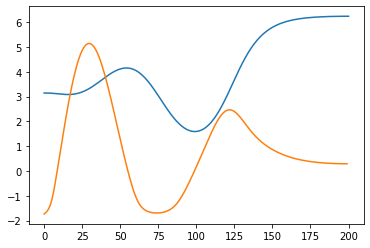

In [8]:
# @title pendulum
# https://github.com/Bharath2/iLQR/blob/main/examples/pendulum.py
import torch

#state and action dimensions
n_x = 3
n_u = 1
#time step
dt = 0.025

#Construct pendulum dynamics
m, g, l = 1, 10, 1
def f(x, u):
    sin, cos, omega = x
    theta = torch.arctan2(sin, cos)
    alpha = (u[0] - m*g*l*torch.sin(theta + torch.pi))/(m*l**2)
    theta_n = theta + omega*dt
    return torch.cat((torch.sin(theta_n).unsqueeze(0), torch.cos(theta_n).unsqueeze(0), omega.unsqueeze(0) + alpha*dt),0)
Pendulum = Dynamics.Discrete(f)


#Construct cost to swing up Pendulum
#theta = 0 --> sin(theta) = 0, cos(theta) = 1
x_goal = torch.tensor([0., 1., 0.])
Q  = torch.diag(torch.tensor([0., 1., 0.1]))
R  = torch.diag(torch.tensor([0.1]))
QT = torch.diag(torch.tensor([0., 100., 100.]))
#Add constraints on torque input (2Nm to -2Nm)
# cons = Bounded(u, high = [2], low = [-2])
def cons(u): return Bounded(u, high = torch.tensor(2.), low = torch.tensor(-2.))
SwingUpCost = Cost.QR(Q, R, QT, x_goal, cons)


#initialise the controller
controller = iLQR(Pendulum, SwingUpCost)

#initial state
#theta = pi --> sin(theta) = 0, cos(theta) = -1
x0 = torch.tensor([0., -1., 0.])
#initial guess
us_init = torch.randn(200, n_u)*0.01
#get optimal states and actions
xs, us, cost_trace = controller.fit(x0, us_init)


#Plot theta and action trajectory
import matplotlib.pyplot as plt
theta = torch.arctan2(xs[:, 0], xs[:, 1])
theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
plt.plot(theta)
plt.plot(us)
plt.show()


